# Computing the time average of LAI and fAPAR using inverse variance weights

## Introduction

LAI (Leaf Area Index; total one-sided leaf area per unit of horizontal land surface area) and fAPAR (fraction of Absorbed Photosynthetically Active Radiation) are two quantities which are important for the description of the land vegetation and its mass and energy exchange. LAI and fAPAR retrieved with satellite remote sensing is documented in and available through the CDS ([Copernicus Data Store](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=overview)). Time series of unsmoothed satellite derived LAI and fAPAR can show noise and natural fluctuations. By computing a monthly average these can be reduced. Each grid cell comes with a retrieval uncertainty which can be used to give appropriate weight to retrievals with different uncertainty in the average computation. Here, we use inverse variance weights, which is the optimal estimator of the average of $N$ uncorrelated measurements in the sense that the estimated average has the least variance among all the weighted averages.

<a id='formulae'></a>
## Inverse Variance Weights
Given a sequence of independent observations $y_i$ with variances $\sigma_{i}^2$, the inverse-variance weighted average is given by
\begin{equation}
\hat{y} = \frac{\sum_i y_i/\sigma_{i}^2}{\sum_i 1/\sigma_{i}^2}.
\end{equation}
The variance of $\hat{y}$ is
\begin{equation}
Var(\hat{y}) = \frac{1}{\sum_i 1/\sigma_{i}^2}.
\end{equation}
Computing $Var(\hat{y})$ first, we can use it to save some operations:
\begin{equation}
\hat{y} = Var(\hat{y}) \sum_i y_i/\sigma_{i}^2
\end{equation}

## Steps:
- get data from the CDS
- unpack data
- apply quality flags
- compute the inverse variance weighted average over the time period defined by the downloaded files
- fix metadata in the result file
- write the result to file
- create a plot

## Computational challenges
- Depending on the load on the CDS, receiving and downloading the data may take a long time. If the notebook recognises that the data has been downloaded already (e.g. in a previous run) it skips that step.
- Global maps of LAI and fAPAR in 1 km resolution take a lot of memory during the computations. Therefore this example uses `xarray` with `dask`, which will atomatically parallelise the computation and keep only fractions of the whole layer in memory at a time.

# Required packages
The notebook use `xarray` and `datetime` globally. Other packages are included locally. These are `cdsapi` to access the CDS, `tarfile` to unpack the data, `numpy` for the computations, and `os` and `sys`. The visualisation uses `matplotlib` and `cartopy`.

In [1]:
import xarray as xr
from datetime import datetime

In [2]:
 %pip install 'cdsapi>=0.7.0'


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Request data from the CDS programmatically with the CDS API


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: URL and KEY which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (https://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/how-to-api and copy the string of characters listed after "key:". Replace the ######### below with this string.


In [2]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '##############'

In [3]:
def get_data(file):
    import cdsapi
    import os.path
    if os.path.isfile(file):
        print("file",file,"already exists.")
    else:
        c = cdsapi.Client(url=URL,key=KEY)
        c.retrieve(
            'satellite-lai-fapar',
            {
                'variable': [
                    'fapar', 'lai',
                ],
                'satellite': ['proba'],
                'sensor': 'vgt',
                'horizontal_resolution': ['1km'],
                'product_version': 'v3',
                'year': ['2019'],
                'month': ['05'],
                'nominal_day': [
                    '10', '20', '31',
                ],
                'format': 'tgz',
            },
            file)

starttime = datetime.now()
file = 'data.tgz'
get_data(file)
print('got data,       elapsed:',datetime.now()-starttime)

2024-09-27 09:50:44,728 WARNING [2024-09-27T07:50:44.723388] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-09-27 09:50:44,810 INFO status has been updated to accepted
2024-09-27 09:50:46,388 INFO status has been updated to running
2024-09-27 09:50:48,703 INFO status has been updated to successful


36241651cf157d7737b42642ae8dbcce.gz:   0%|          | 0.00/3.41G [00:00<?, ?B/s]

got data,       elapsed: 0:12:26.439937


The CDS tutorial also describes how the CDS database search can be used to generate CDS API requests which can be emplaced in `get_data` to modify it to the user's needs.

## Unpacking
We need the individual files from the archive to open them with `xarray`'s `open_mfdataset` in the next step. This will effectively duplicate the data on disk. Package `tarfile` is used to unpack the data retrieved from the CDS. It returns an object which can be iterated over to get the list of files which is iterated over to check whether the file is already present or needs to be extracted.

In [4]:
def unpack_data(file):
    import tarfile
    import os.path
    tf = tarfile.open(name=file,mode='r')
    print('opened tar file,  elapsed:',datetime.now()-starttime)
    tf.list()
    print('listing,     elapsed:',datetime.now()-starttime)
    # just extract what is not present:
    for xfile in tf:
        if os.path.isfile(xfile.name) == False:
            print('extracting ',xfile.name)
            tf.extract(member=xfile.name,path='.') # uses current working directory        
        else:
            print('present    ',xfile.name)
    return tf

starttime = datetime.now()
tarfileinfo = unpack_data(file)
print('unpacked data,    elapsed:',datetime.now()-starttime)    

opened tar file,  elapsed: 0:00:00.002834
?rw-r--r-- root/root  648901232 2024-09-26 12:33:42 c3s_FAPAR_20190510000000_GLOBE_PROBAV_V3.0.1.nc 
?rw-r--r-- root/root  666362545 2024-09-26 12:38:26 c3s_FAPAR_20190520000000_GLOBE_PROBAV_V3.0.1.nc 
?rw-r--r-- root/root  682841250 2024-09-26 12:48:04 c3s_FAPAR_20190531000000_GLOBE_PROBAV_V3.0.1.nc 
?rw-r--r-- root/root  542358017 2024-09-26 12:51:57 c3s_LAI_20190510000000_GLOBE_PROBAV_V3.0.1.nc 
?rw-r--r-- root/root  558949918 2024-09-26 12:56:37 c3s_LAI_20190520000000_GLOBE_PROBAV_V3.0.1.nc 
?rw-r--r-- root/root  579263205 2024-09-26 13:00:12 c3s_LAI_20190531000000_GLOBE_PROBAV_V3.0.1.nc 
listing,     elapsed: 0:00:05.076151
extracting  c3s_FAPAR_20190510000000_GLOBE_PROBAV_V3.0.1.nc
extracting  c3s_FAPAR_20190520000000_GLOBE_PROBAV_V3.0.1.nc
extracting  c3s_FAPAR_20190531000000_GLOBE_PROBAV_V3.0.1.nc
extracting  c3s_LAI_20190510000000_GLOBE_PROBAV_V3.0.1.nc
extracting  c3s_LAI_20190520000000_GLOBE_PROBAV_V3.0.1.nc
extracting  c3s_LAI_20190

Note the size of the files. They are over than 0.5 GB each *in compressed storage* (netCDF internal compression). This demonstrates how effective this compression is, i.e. you can see that the sum of the size almost equals the size of the `tgz`-archive. This means that the `gzip` compression run on the archive has not found much to compress any more. On these particular files, the compression ratio almost reaches a factor of 10. Internally these file use another compression mechanism on top of this by storing most of the data in limited precision to 16-bit unsigned integers. In python they get expanded to 32-bit floats or even 64-bit doubles, which gives another factor of 2 or 4. Thus three dates of LAI with auxiliary variables would take up about 19 GB in memory *if they were processed simultaneously*. And this estimate is not including storage for intermediated results and output. This notebook works around this bottlenck.

## Reading the data
The data are prepared for reading by passing their names to an `xarray` multi-file object called `filedata` here. This will enable `dask` to work in parallel on multiple files and to hold only subsets in memory. If you uncomment the line `#varname = 'fAPAR' # use this for fAPAR`, the subsequent computations will be done for fAPAR instead of LAI.


In [5]:
starttime = datetime.now()
varname = 'LAI' # use this for LAI
#varname = 'fAPAR' # use this for fAPAR
uncname = varname + '_ERR' # name of uncertainty layer
# extract the file names containting `varname` from `tarfileinfo`
inputfiles = [] # start with empty list
for xfile in tarfileinfo:
    if varname.casefold() in xfile.name.casefold():
        inputfiles.append(xfile.name)
# give the list to an `xarray` multi-file object
#
filedata = xr.open_mfdataset(inputfiles,chunks='auto',parallel=True)
print('got file names, elapsed:',datetime.now()-starttime)

got file names, elapsed: 0:00:01.573129


## Applying quality flags
TIP-LAI and -fAPAR come with a set of informational and quality flags, stored in the layer `retrival_flag`. We are using the hexadecimal representation `0x1C1` of the bit array `111000001`, here, to avoid cells with the conditions `obs_is_fillvalue`, `tip_untrusted`,`obs_unusable`, and `obs_inconsistent`. The [PUG](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=documentation) gives guidance on the selection of these flags. In the end, we must not forget to define the units of the result:

In [6]:
def apply_flags(data,fielddict):
    import numpy as np
    func     = lambda val, flags : np.where( (np.bitwise_and(flags.astype('uint32'),0x1C1) == 0x0 ), val, np.nan )
    units = data[fielddict['variable']].attrs['units']
    clean_data = xr.apply_ufunc(func,data[fielddict['variable']],data[fielddict['flags']],dask="allowed",dask_gufunc_kwargs={'allow_rechunk':True})
    # set units of result:
    clean_data.attrs['units'] = units
    return clean_data

starttime = datetime.now()
filedata[varname] = apply_flags(filedata,{'variable':varname,'flags':'retrieval_flag'})
filedata[uncname] = apply_flags(filedata,{'variable':uncname,'flags':'retrieval_flag'})
print('applied flags,  elapsed:',datetime.now()-starttime)

applied flags,  elapsed: 0:00:00.032871


## Computing the average
The subroutine starts by defining the two lambda-functions for the variance and the average itself as given in section [above](#formulae).
`xarray`'s `apply_ufunc` is used to enqueue them to `dask`. Since the average is a reduction along the time dimension, this is identified in the `input_core_dims` argument. Where there is missing data, the `varfunc` result will be `inf` or `-inf`, which needs to be set to `nan` (the value used for missing data internally by `xarray`). Also, names and units are set, and the variance is converted to 'standard error' or uncertainy by taking the square root before the subroutine returns the results.

In [7]:
def average_ivw(data,fielddict):
    import numpy as np
    # formula for the variance of the result:
    varfunc = lambda unc : 1. / np.nansum( (  1. / unc**2 ), axis=2 )
    # formula for the inverse variance weighted mean:
    avgfunc  = lambda val, unc, rvarsum : np.nansum( ( val / unc**2 ),axis=2 ) * rvarsum
    units = data[fielddict['variable']].attrs['units']
    # enforce parallelism with xarray and dask:
    variance_ivw = xr.apply_ufunc(varfunc,data[fielddict['uncertainty']],dask="allowed",input_core_dims=([['time']]))
    ave_ivw = xr.apply_ufunc(avgfunc,data[fielddict['variable']],data[fielddict['uncertainty']],variance_ivw,dask="allowed",input_core_dims=([['time'],['time'],[]]),exclude_dims={'time'})
    # replace any non-finite results with np.nan:
    ave_ivw = ave_ivw.where(np.isfinite(ave_ivw))
    # replace any non-finite results with np.nan and convert variance to uncertainty:
    uncertainty_ivw = np.sqrt(variance_ivw).where(np.isfinite(variance_ivw))
    # correct name of layer after computation
    ave_ivw = ave_ivw.rename(fielddict['variable'])
    uncertainty_ivw = uncertainty_ivw.rename(fielddict['uncertainty'])
    # set units of results:
    ave_ivw.attrs['units'] = units
    #    uncertainty_ivw[fielddict['uncertainty']].attrs['units'] = units
    uncertainty_ivw.attrs['units'] = units
    return ave_ivw, uncertainty_ivw

starttime = datetime.now()
average,ave_uncertainty = average_ivw(filedata,{'variable':varname,'uncertainty':uncname,'flags':'retrieval_flag'})
print('setting up average, elapsed  :',datetime.now()-starttime)

setting up average, elapsed  : 0:00:00.018484


## Setting metadata
Before writing the results to file, further metadata are set, in order to make the file self-documenting. This is good practice, not only if such files are exchanged between colleagues, but also to allow for oneself to trace back and understand the results of one's own work, especially if some time has elapsed since the data was processed.


In [8]:
#
# copy, set, and update file and variable attributes
#
starttime = datetime.now()
average.attrs['long_name'] = 'monthly averaged ' + varname + ' using inverse variance weights'
ave_uncertainty.attrs['long_name'] = varname + ' standard error after averaging with inverse variance weights'
# create a merged object which contains the average and its standard error
output = xr.merge((average,ave_uncertainty))
# inherit the global attributes of the input data:
output.attrs = filedata.attrs
# document the processing by prepending to the `history` attribute:
def cmdline_as_string():
    import sys
    import os
    command_line = os.path.basename(sys.argv[0])
    for s in sys.argv[1:]:
        command_line += ' ' + s
    return command_line
output.attrs['history'] = str(datetime.now()) + ': ' + cmdline_as_string() + '\n' + output.attrs['history']
#
# adapt attributes:
#
output.attrs['long_name'] = output.attrs['long_name'] + ' after application of inverse variance weighted monthly mean'
output.attrs['title'] = output.attrs['title'] + ' after application of inverse variance weighted monthly mean'
output.attrs['summary'] = 'inverse variance weighted average of ' + varname
#
# compute and set a time for the result
#
intimes = filedata['time']
outtime = intimes[0] + ( intimes[-1] - intimes[0] ) / 2
output['time'] = outtime
output = output.expand_dims(dim='time',axis=0)
output.attrs['start_date'] = str(intimes[0].data)
output.attrs['end_date'] = str(intimes[-1].data)
print('after setting file atts:',datetime.now()-starttime)


after setting file atts: 0:00:00.013813


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xarray/core/dataset.py:4743: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  warnings.warn(


Until now, `dask` has only collected information on how to do the actual calculations. But it is already able to predict the size of the resulting object:

In [9]:
print(filedata.nbytes*2**(-30)," GB input")
#
# even if the computation is delayed by dask, the output data volume is already known:
#
print(output.nbytes*2**(-30)," GB output (anticipated)")

28.262746359221637  GB input
4.710805423557758  GB output (anticipated)


The computation is finally triggered when the data is written to a file. `NetCDF` internal compression is set to `zlib` level 4 for both output layers. Runs on the test system showed about 2 GB of memory usage for this example. Be prepared to see (and ignore) run-time errors about `divide by zero` and `invalid value`, which are triggered by cells with missing data.

In [10]:
#
# output to file triggers the delayed computation:
#
def write_result(output,outfile):
    import os.path
    if os.path.isfile(outfile):
        print("file",outfile,"already exists. Processing skipped.")
    else:
        output.to_netcdf(outfile,mode='w',encoding={varname:{"zlib": True, "complevel": 4,},uncname:{"zlib": True, "complevel": 4}})
    return

starttime = datetime.now()
outfile = varname + '-mean.nc'
write_result(output,outfile)
filedata.close()
output.close()
print('After delayed computations :',datetime.now()-starttime)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


After delayed computations : 0:02:12.407966


## Plotting
To interacively visualise the result, we recommend [snap](https://earth.esa.int/eogateway/tools/snap), but of course, we can give python a try as well. The following script plots two different regions, Europe and the full dataset. Be prepared to wait a couple of minutes and to see heavy memory usage for the global one. With minor modifications, the following cell can also be run stand-alone (`varname` and `outfile` need to be set). It creates two plots, one centred over Europe, and one using the full extent of the data. Note that both plots do not show the data at their full resolution, using some internal resampling of the `imshow`-method from `pyplot`.

<xarray.DataArray 'LAI' (lat: 4480, lon: 6720)> Size: 120MB
[30105600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 54kB -20.0 -19.99 -19.98 -19.97 ... 39.97 39.98 39.99
  * lat      (lat) float64 36kB 70.0 69.99 69.98 69.97 ... 30.03 30.02 30.01
    time     datetime64[ns] 8B 2019-05-20T12:00:00
Attributes:
    units:      m2.m-2
    long_name:  monthly averaged LAI using inverse variance weights


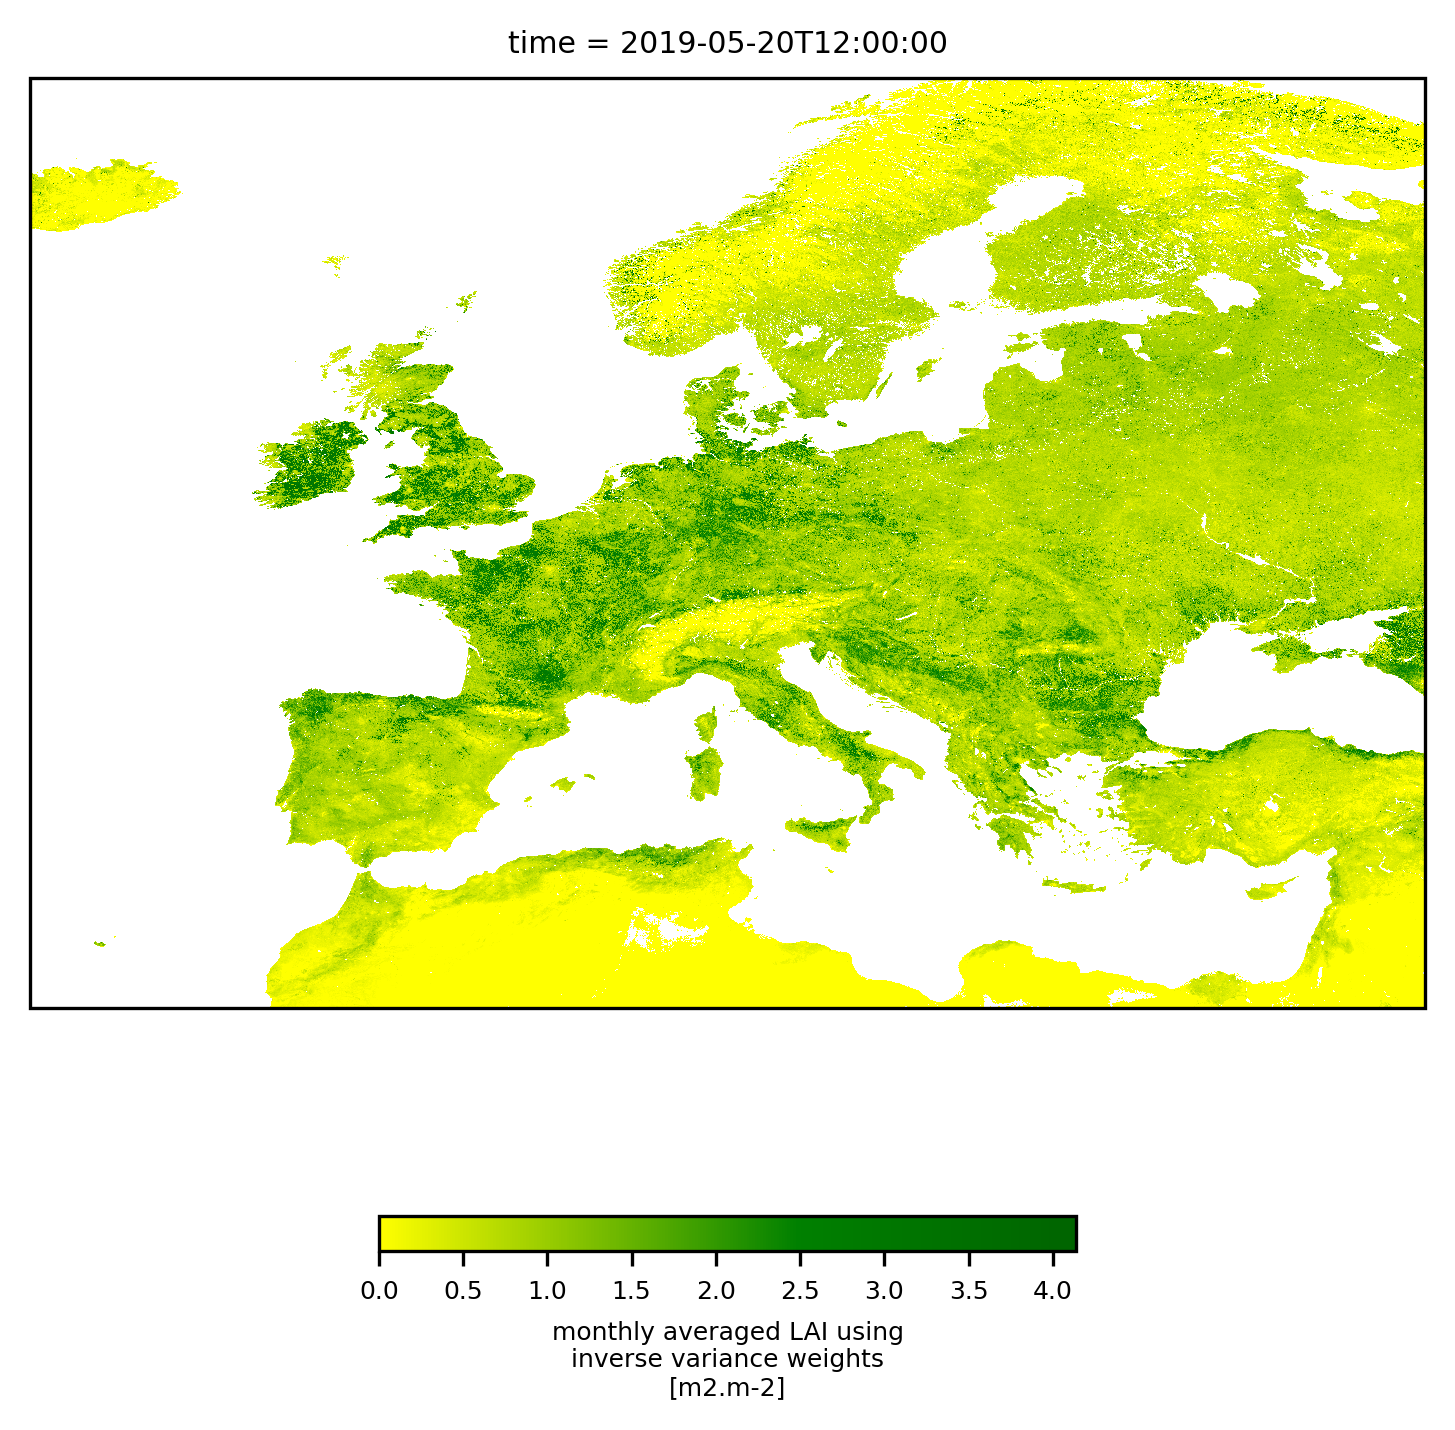

After first plot, elapsed : 0:00:02.744682
<xarray.DataArray 'LAI' (lat: 15680, lon: 40320)> Size: 3GB
[632217600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 125kB 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
    time     datetime64[ns] 8B 2019-05-20T12:00:00
Attributes:
    units:      m2.m-2
    long_name:  monthly averaged LAI using inverse variance weights


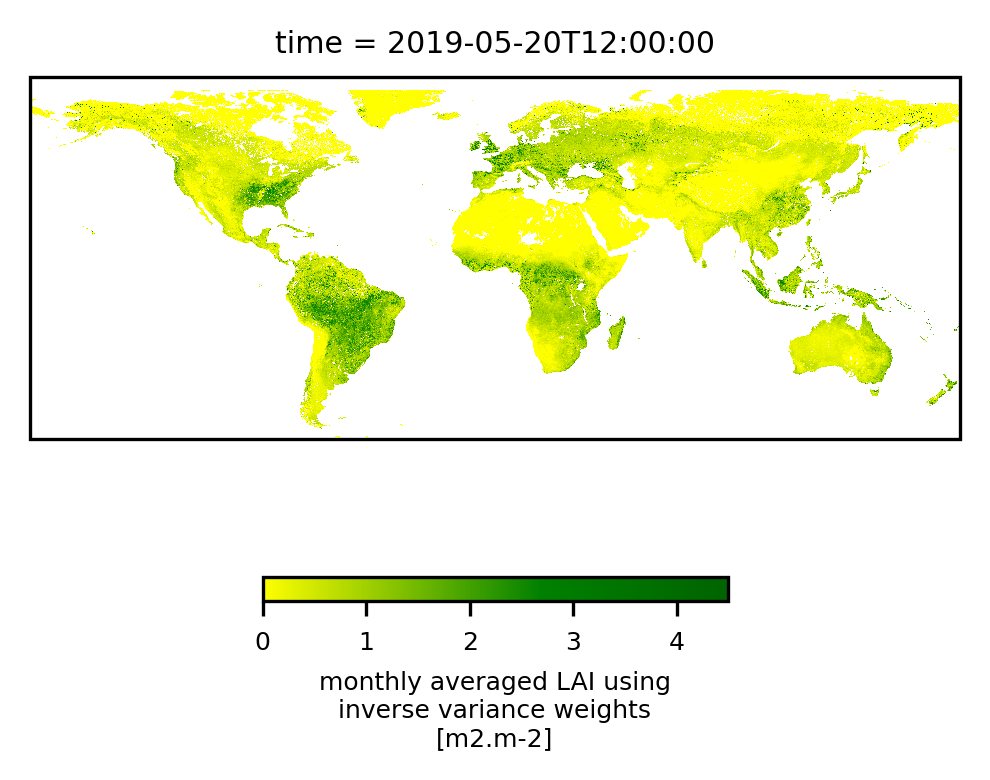

Done plotting, elapsed : 0:00:19.595847


In [11]:
def plot_region(dataslice,region,size):
    # Libraries for plotting and geospatial data visualisation
    import cartopy.crs as ccrs
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    # show data attributes
    print(dataslice)
    # define a colour map; green colour should start where LAI reaches 1
    mycmap = mpl.colors.LinearSegmentedColormap.from_list('lai_cmap',[(0,'yellow'),(0.6,'green'),(1,'darkgreen')])
    plt.rc('legend', fontsize=6)
    plt.rc('font', size=6)
    fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree())) # Mollweide() is too slow.
    fig.set_size_inches(size,size)
    fig.set_dpi(300)
    dataslice.plot.imshow(
        ax=axis,
        transform=ccrs.PlateCarree(),  # this is important!
        cbar_kwargs={"orientation": "horizontal", "shrink": 0.5},
        interpolation='none',
        #robust=True,
        cmap = mycmap
    )
    #axis.coastlines(resolution='50m')  # cartopy function, optional
    # save to file
    plt.savefig(varname + '_' + region + '.png',dpi=300)
    # display a screen version
    plt.show()
    return

starttime = datetime.now()
# read results from file to avoid a second evaluation
filedata = xr.open_dataset(outfile)
plot_region(filedata[varname].sel(dict(lat=slice(70,30), lon=slice(-20, 40))).isel(time=0),region='Europe',size=6)
print('After first plot, elapsed :',datetime.now()-starttime)
plot_region(filedata[varname].isel(time=0),region='Global',size=4)
filedata.close()
print('Done plotting, elapsed :',datetime.now()-starttime)

The output of the above cell contains two figures, inlcuding heading, colour key, and caption, showing monthly averaged LAI in Europe (top figure) and globally (bottom figure).

## Cleaning up
After running this notebook, some files will remain in the working directory (the directory from which you selected this notebook). These are:
- data.tgz -- the compressed archive of the downloaded files from the CDS
- c3s_FAPAR_20190510000000_GLOBE_PROBAV_V3.0.1.nc, c3s_FAPAR_20190531000000_GLOBE_PROBAV_V3.0.1.nc, c3s_LAI_20190520000000_GLOBE_PROBAV_V3.0.1.nc, c3s_FAPAR_20190520000000_GLOBE_PROBAV_V3.0.1.nc, c3s_LAI_20190510000000_GLOBE_PROBAV_V3.0.1.nc, c3s_LAI_20190531000000_GLOBE_PROBAV_V3.0.1.nc -- the data extracted from the archive
- LAI-mean.nc -- the computed average as netCDF file
- LAI_Europe.png, LAI_Global.png -- the LAI images file generated by the plot script
- fAPAR-mean.nc, fAPAR_Europe.png, fAPAR_Global.png -- the corresponding files for fAPAR if you have re-run the notebook from step 4, setting `varname = 'fAPAR'`)

All these files will be re-generated if the notebook is run again. However, if you want to experiment with some cells like the plotting just leave them there which will allow the notebook to skip some time-consuming steps.


## Key messages
- Uncertainties provided with the data help to improve the quality of the time average.
- Depending on the statistical model, inverse variance weights may be a good choice for your application
- Often, quality flags exist which mark data that may be unreliable and should be ommited for general purposes.
- Global datasets can be huge, it is worth thinking about parallel processing, e.g. using `dask`.
- It is good practice to maintain units and other metainfo, even in intermediate files.